In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/mnist1')
writer = SummaryWriter('runs/mnist2')
###################################################

In [3]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#hyper parameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 128
learning_rate = 0.01

In [5]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [6]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [8]:
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


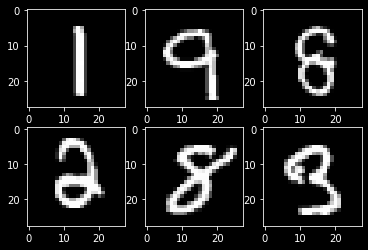

In [9]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(samples[i][0], cmap='gray')

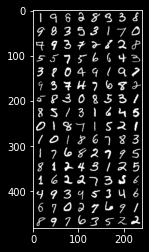

In [10]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
# writer.close()
# sys.exit()
###################################################
plt.imshow(img_grid[0],cmap='gray')

In [11]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

model = NeuralNet(input_size, hidden_size, num_classes)
model.to(device)

NeuralNet(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=10, bias=True)
)

In [12]:
writer.add_graph(model, samples.reshape(-1, 28*28).to(device))
# writer.close()
# images = samples[0][0].reshape(-1, 28*28).to(device)
# writer.add_graph(model,images)

In [ ]:
# writer.close()

In [13]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# training loop
running_loss = 0
running_correct = 0

n_total_step = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # 100, 1, 28, 28
    # 100, 784
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    # forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backwards
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    running_correct += (predicted == labels).sum().item()    

    if (i+1) % 100 ==0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_step} loss {loss.item():.4f} runningloss {running_loss/100}')
      ############## TENSORBOARD ########################
      writer.add_scalar('training loss', running_loss / 100, epoch * n_total_step + i)
      writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_step + i)
      running_correct = 0
      running_loss = 0.0
      ###################################################

epoch 1 / 2, step 100 / 469 loss 0.2714 runningloss 0.45009676046669483
epoch 1 / 2, step 200 / 469 loss 0.1881 runningloss 0.2195601174980402
epoch 1 / 2, step 300 / 469 loss 0.1575 runningloss 0.17279092855751516
epoch 1 / 2, step 400 / 469 loss 0.1142 runningloss 0.15856501039117574
epoch 2 / 2, step 100 / 469 loss 0.0913 runningloss 0.21998190965503453
epoch 2 / 2, step 200 / 469 loss 0.1049 runningloss 0.10259592099115253
epoch 2 / 2, step 300 / 469 loss 0.1759 runningloss 0.12165388448163866
epoch 2 / 2, step 400 / 469 loss 0.0427 runningloss 0.10946042848750949


In [15]:
class_labels = []
all_sm_op = []

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

    batch_sm_op = [F.softmax(output, dim=0) for output in outputs]
    all_sm_op.append(batch_sm_op)
    class_labels.append(predicted)
  
  all_sm_op = torch.cat([torch.stack(batch) for batch in all_sm_op])
  class_labels = torch.cat(class_labels)

  acc = 100.0 * n_correct / n_samples
  print(f'accuracy {acc:.4f}')
  ############## TENSORBOARD ########################
  classes = range(10)
  for i in classes:
      labels_i = class_labels == i
      preds_i = all_sm_op[:, i]
      writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
      writer.close()
  ###################################################

accuracy 95.6400


ValueError: weights should have the same shape as a.

In [16]:
############## TENSORBOARD ########################
classes = range(10)
for i in classes:
    labels_i = class_labels == i
    preds_i = class_preds[:, i]
    writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
    # writer.add_pr_curve()
    writer.close()
###################################################

NameError: name 'class_preds' is not defined

In [ ]:
len(preds_i)

In [ ]:
class_labels=torch.cat(class_labels)

In [ ]:
class_labels == 0

In [ ]:
images, labels=next(iter(test_loader))

In [ ]:
images = images.reshape(-1, 28*28).to(device)
labels = labels.to(device)
outputs = model(images)

_, predictions = torch.max(outputs, 1)
n_samples += labels.shape[0]
n_correct += (predictions == labels).sum().item()

In [ ]:
class_labels = []
all_sm_op = []

batch_sm_op = [F.softmax(output, dim=0) for output in outputs]
all_sm_op.append(batch_sm_op)
class_labels.append(predicted)

In [ ]:
len(all_sm_op[0]),predicted.shape

In [ ]:
i= iter(model.parameters())

In [ ]:
dir(nn.Module)


In [ ]:
print(model)

In [ ]:
from torchvision import models
from torchsummary import summary

In [ ]:
summary(model, (100,28*28))

In [ ]:
# import tensorflow as tf
import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
netstat -ano | findstr :6006
taskkill /F /PID 11544

In [ ]:
torch.stack(next(iter(all_sm_op)))

In [ ]:
next(iter(all_sm_op))

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist1')
###################################################

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()

############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)
#writer.close()
#sys.exit()
###################################################

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

############## TENSORBOARD ########################
writer.add_graph(model, example_data.reshape(-1, 28*28).to(device))
#writer.close()
#sys.exit()
###################################################

# Train the model
running_loss = 0.0
running_correct = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            ###################################################

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

        class_preds.append(class_probs_batch)
        class_labels.append(predicted)

    # 10000, 10, and 10000, 1
    # stack concatenates tensors along a new dimension
    # cat concatenates tensors in the given dimension
    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    ############## TENSORBOARD ########################
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        # writer.add_pr_curve()
        writer.close()
    ###################################################

Epoch [1/1], Step [100/938], Loss: 0.1991
Epoch [1/1], Step [200/938], Loss: 0.4345
Epoch [1/1], Step [300/938], Loss: 0.3318
Epoch [1/1], Step [400/938], Loss: 0.3237
Epoch [1/1], Step [500/938], Loss: 0.2790
Epoch [1/1], Step [600/938], Loss: 0.1451
Epoch [1/1], Step [700/938], Loss: 0.1394
Epoch [1/1], Step [800/938], Loss: 0.1200
Epoch [1/1], Step [900/938], Loss: 0.2628
Accuracy of the network on the 10000 test images: 96.59 %


TypeError: add_pr_curve() missing 3 required positional arguments: 'tag', 'labels', and 'predictions'